# **SENTIMENT ANALYSIS OF CUSTIMER REVIEWS**
This project performs sentiment analysis on customer reviews using various machine learning and deep learning models. It covers preprocessing, feature extraction, and building models like Logistic Regression, Support Vector Machines (SVM), Artificial Neural Networks (ANN), Long Short-Term Memory Networks (LSTM), and Gated Recurrent Unit Networks (GRU). The dataset consists of 150,000 labeled customer reviews.

### Import Libraries
In this block, all the necessary libraries for preprocessing, machine learning, deep learning, and visualization are imported. These include:
- NLTK (Natural Language ToolKit) for natural language processing
- Scikit-learn for machine learning models and metrics
- TensorFlow for deep learning models
- Matplotlib for visualization

In [ ]:
import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, GlobalAveragePooling1D, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import nltk

nltk.data.path.append('/Users/shiven/nltk_data')

2024-11-25 15:54:38.172880: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Download the NLTK Data
- Necessary NLTK resources like `punkt`, `wordnet`, `averaged_perceptron_tagger`, and `omw-1.4` are downloaded to ensure that tokenization, lemmatization, and POS tagging work correctly.

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /Users/shiven/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shiven/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shiven/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /Users/shiven/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/shiven/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

### Initialize Lemmatizer and Helper Functions
- **WordNet Lemmatizer**: The WordNet Lemmatizer is a tool from NLTK that reduces words to their base or root form, called the **lemma**. Unlike stemming, which simply removes prefixes or suffixes, lemmatization considers the word's meaning and its part of speech (POS) to produce a linguistically accurate root form. For example:
  - "running" → "run" (if it's a verb)
  - "better" → "good" (if it's an adjective)

- **Why Use WordNet Lemmatizer?**
  - It ensures that words like "running", "runs", and "ran" are all normalized to "run", improving the quality of text analysis.
  - It works with WordNet, a lexical database for the English language, to accurately find the base form based on the word's context and POS.

- **Helper Function (`get_wordnet_pos`)**:
  - The `get_wordnet_pos` function converts POS tags (e.g., "NN" for nouns, "VB" for verbs) from the NLTK POS tagger into WordNet-compatible tags. This mapping is essential because the lemmatizer requires POS information to properly lemmatize words.
  - Example Mapping:
    - NLTK Tag `JJ` → WordNet Tag `ADJ` (adjective)
    - NLTK Tag `NN` → WordNet Tag `NOUN`
    - NLTK Tag `VB` → WordNet Tag `VERB`
    - NLTK Tag `RB` → WordNet Tag `ADV` (adverb)
    
This ensures the WordNet Lemmatizer can accurately handle words based on their grammatical role in the sentence.

In [ ]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word], lang="eng")[0][1][0].upper()
    tag_dict = {'J': wordnet.ADJ, 'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

### Text Preprocessing with Lemmatization
- A preprocessing function is defined to clean the text data.
- Steps include:
  1. Lowercasing the text.
  2. Removing special characters and numbers.
  3. Tokenizing the text.
  4. Lemmatizing each token using the `get_wordnet_pos` helper function.
- The function includes error handling to debug any issues with specific rows.

In [ ]:
def preprocess_text(text):
    try:
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)  
        text = re.sub(r'\d+', '', text)  
        tokens = word_tokenize(text)  
        lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]  
        return ' '.join(lemmatized_tokens)
    except Exception as e:
        print(f"Error processing text: {text}")
        print(f"Exception: {e}")
        return text

### Load Dataset
- The dataset is loaded using `pandas`.
- The size of the dataset and the first few rows are displayed.
- Class distributions are printed to understand the balance between labels.

In [ ]:
data = pd.read_csv('reviews.csv')   # replace with your dataset file name and path
print(f"Dataset size: {len(data)}")
print(data.head())

class_counts = data['label'].value_counts()
print(f"Class counts:\n{class_counts}")

Dataset size: 150000
   label                                               text
0      0  Reference Yes, Learning or Instruction No: I p...
1      0  NO!!!!!!I will give it 1 star.: This doll is n...
2      0  Neat Features/Uncomfortable: I bought this wit...
3      1  Progressive-Underground divas??? where's the v...
4      0  The theif who stole a week.: What a stinker! I...
Class counts:
label
0    75034
1    74966
Name: count, dtype: int64


### Apply Preprocessing to the Dataset
- Null values in the `text` column are replaced with empty strings.
- All entries in the `text` column are converted to strings.
- The `preprocess_text` function is applied to the `text` column to clean and preprocess the data.

In [ ]:
data['text'] = data['text'].fillna('') 
data['text'] = data['text'].astype(str) 
data['text'] = data['text'].apply(preprocess_text)

### Tokenization
- **What is Tokenization?**
  - Tokenization is the process of breaking a stream of text into smaller units called **tokens**. These tokens can be words, phrases, or even characters, depending on the application.
  - For example:
    - Sentence: "I love programming!"
    - Tokens: ["I", "love", "programming", "!"]

  - Tokenization is a crucial preprocessing step in NLP tasks, as it transforms raw text into a structured format that can be understood by machine learning models.

- **Keras's `Tokenizer`**:
  - Keras provides a `Tokenizer` class to preprocess text data for deep learning models. It converts text into sequences of integers, where each integer represents a unique word in the vocabulary.
  - Key Features of `Tokenizer`:
    1. **Word Indexing**:
       - The `Tokenizer` creates a dictionary (`word_index`) that maps each unique word to an integer.
       - Example: {"I": 1, "love": 2, "programming": 3}
    2. **Text-to-Sequence Conversion**:
       - It converts each sentence into a sequence of integers based on the `word_index`.
       - Example: "I love programming" → [1, 2, 3]
    3. **Handles Out-of-Vocabulary Words**:
       - Words that are not in the `word_index` can be mapped to a special "out of vocabulary" (OOV) token, ensuring robustness.
    4. **Frequency-based Filtering**:
       - You can limit the vocabulary size to the `num_words` most frequent words, which reduces noise from rare words.

- **Why Use Keras's `Tokenizer`?**
  - It simplifies the process of converting text data into numerical data, which is essential for deep learning models.
  - It supports preprocessing for large datasets and integrates seamlessly with other Keras tools, such as embedding layers.

- **Output of Tokenization**:
  - After applying the `Tokenizer`:
    1. Each document in the dataset is represented as a list of integers (word sequences).
    2. The `word_index` provides a mapping of unique words to integers.
    3. The number of unique tokens in the dataset is displayed, giving insight into the vocabulary size.

This step is crucial for preparing the text data for embedding layers and other deep learning architectures.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
word_index = tokenizer.word_index
print(f"Number of unique tokens: {len(word_index)}")

Number of unique tokens: 218265


### Padding Sequences
- The tokenized sequences are padded to ensure uniform length using Keras's `pad_sequences`.
- This step is critical for feeding the data into deep learning models.


In [ ]:
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['label'], test_size=0.2, random_state=42)

### Load GloVe Embeddings

- **What is GloVe?**
  - GloVe (Global Vectors for Word Representation) is a popular method for obtaining word embeddings, which are dense vector representations of words in a continuous vector space.
  - Developed by researchers at Stanford, GloVe is based on the principle of using word co-occurrence statistics in a large text corpus to learn meaningful vector representations for words.
  - Pretrained GloVe embeddings, such as `glove.6B.100d`, provide vector representations for words trained on massive corpora like Wikipedia and Gigaword datasets.

- **Principle Behind GloVe**:
  - GloVe is designed to learn word vectors such that the dot product (or cosine similarity) of two word vectors corresponds to the log-probability of their co-occurrence in a corpus.
  - Words that frequently co-occur in similar contexts will have similar vector representations, capturing their semantic similarity.
  - For example:
    - Words like "king" and "queen" are closer in the embedding space because they share similar contexts in the corpus.
    - The analogy `king - man + woman ≈ queen` arises naturally due to the embedding's structure.
    
- **Why Use GloVe?**
  - **Semantic Relationships**:
    - GloVe embeddings capture semantic similarity and relationships between words.
    - For example, "Paris" - "France" + "Italy" ≈ "Rome".
  - **Pretrained on Large Datasets**:
    - Pretrained GloVe embeddings are available for various dimensions (e.g., 50d, 100d, 200d, 300d) and corpora, saving time and computational resources.
  - **Dense and Continuous Representations**:
    - GloVe embeddings represent each word as a fixed-length dense vector, suitable for machine learning models.

- **Embedding Matrix**:
  - After loading GloVe embeddings, an **embedding matrix** is created where:
    - Rows correspond to words in the dataset vocabulary.
    - Columns correspond to the vector dimensions (e.g., 100 for `glove.6B.100d`).
  - Words missing from GloVe embeddings are initialized with zeros.

- **Applications of GloVe**:
  - Sentiment analysis, machine translation, question answering, and more.
  - Improves model performance by providing a meaningful starting point for word representations.

This step prepares the embedding matrix, which serves as input to the embedding layer in the deep learning models.

In [ ]:
embedding_index = {}
glove_file = '/Users/shiven/Documents/glove.6B/glove.6B.100d.txt'
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Constructing Feature Matrix by TF-IDF
TF = Term Frequency , IDF = Inverse Document Frequency
tf-idf(i,j)= tf(i,j)*idf(i,j)

idf(i) = log[(Total number of docs)/(Number of docs in which term occurs)]

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(data['text'])
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, data['label'], test_size=0.2, random_state=42)

### Logistic Regression
- A Logistic Regression model is trained on the TF-IDF features.
- The model's accuracy on the test set is printed.
### Support Vector Machine (SVM)
- A LinearSVC model is trained on the TF-IDF features.
- The model's accuracy on the test set is printed.


In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train_tfidf)
lr_predictions = lr.predict(X_test_tfidf)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test_tfidf, lr_predictions)}")

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train_tfidf)
svm_predictions = svm.predict(X_test_tfidf)
print(f"SVM Accuracy: {accuracy_score(y_test_tfidf, svm_predictions)}")

Logistic Regression Accuracy: 0.8857666666666667


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SVM Accuracy: 0.8860666666666667


### Artificial Neural Networks ANN

This code builds and trains an artificial neural network (ANN) for binary text classification using TensorFlow and Keras. The model begins with an embedding layer initialized with pre-trained embeddings (embedding_matrix), which converts input text indices into dense vectors. A global average pooling layer follows to reduce the sequence of embeddings into a single vector. Two dense layers with ReLU activation and dropout regularization are then applied to introduce non-linearity and prevent overfitting. The final output layer uses a sigmoid activation to produce a probability score for classification.

The model is compiled with the Adam optimizer, binary crossentropy loss, and accuracy as the evaluation metric. Early stopping is used to monitor validation loss, halting training if no improvement is seen after three epochs while restoring the best weights. Training is conducted over a maximum of 15 epochs with a batch size of 128, leveraging training and validation data for evaluation. This setup ensures efficient training and robust performance.

In [ ]:
ann_model = Sequential([
    Embedding(input_dim=len(word_index)+1, output_dim=100, weights=[embedding_matrix], trainable=True),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

ann_model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 193s 204ms/step - accuracy: 0.7511 - loss: 0.4787 - val_accuracy: 0.8779 - val_loss: 0.2902
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 389s 415ms/step - accuracy: 0.8911 - loss: 0.2700 - val_accuracy: 0.8721 - val_loss: 0.3002
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 639s 681ms/step - accuracy: 0.9109 - loss: 0.2288 - val_accuracy: 0.8839 - val_loss: 0.2789
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 844s 900ms/step - accuracy: 0.9249 - loss: 0.1963 - val_accuracy: 0.8779 - val_loss: 0.3086
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 193s 206ms/step - accuracy: 0.9352 - loss: 0.1728 - val_accuracy: 0.8794 - val_loss: 0.2998
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 189s 202ms/step - accuracy: 0.9453 - loss: 0.1472 - val_accuracy: 0.8729 - val_loss: 0.3464


### Long Short Term Memory LSTM

This code builds an LSTM-based model for binary text classification. It starts with a pre-trained, non-trainable embedding layer (embedding_matrix) that converts input indices into dense vectors. An LSTM layer with 128 units processes the sequences to capture contextual dependencies. A dense layer with 64 neurons and ReLU activation introduces non-linearity, followed by a sigmoid-activated output layer for classification.

The model is compiled with the Adam optimizer, binary crossentropy loss, and accuracy as the metric. It is trained for up to 15 epochs with a batch size of 64, using training data (X_train, y_train) and validated on test data (X_test, y_test). This setup is designed for handling sequence data effectively and achieving robust classification results.

In [ ]:
lstm_model = Sequential([
    Embedding(input_dim=len(word_index)+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 105s 55ms/step - accuracy: 0.5568 - loss: 0.6800 - val_accuracy: 0.8039 - val_loss: 0.4621
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 110s 59ms/step - accuracy: 0.8405 - loss: 0.3724 - val_accuracy: 0.8763 - val_loss: 0.2917
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 109s 58ms/step - accuracy: 0.8813 - loss: 0.2834 - val_accuracy: 0.8827 - val_loss: 0.2804
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 110s 59ms/step - accuracy: 0.8944 - loss: 0.2554 - val_accuracy: 0.8936 - val_loss: 0.2542
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 107s 57ms/step - accuracy: 0.9068 - loss: 0.2276 - val_accuracy: 0.9010 - val_loss: 0.2398
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 111s 59ms/step - accuracy: 0.9134 - loss: 0.2137 - val_accuracy: 0.9037 - val_loss: 0.2357
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 112s 60ms/step - accuracy: 0.9228 - loss: 0.1957 - val_accuracy: 0.9078 - val_loss: 0.2297
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 111s 59ms/step - accuracy: 

### Gated Recurrent Unit GRU

This code defines a Gated Recurrent Unit (GRU) model for binary text classification. It starts with a pre-trained embedding layer (embedding_matrix), which converts input indices into dense vectors. The embeddings are non-trainable, preserving the pre-trained representations. A GRU layer with 128 units follows, effectively capturing sequential dependencies in the text data.

Next, a dense layer with 64 neurons and ReLU activation introduces non-linearity, followed by an output layer with a sigmoid activation function to generate probabilities for binary classification. The model is compiled using the Adam optimizer, binary crossentropy as the loss function, and accuracy as the evaluation metric.

The model is trained for a maximum of 15 epochs with a batch size of 32, using the training data (X_train, y_train) and validated on the test data (X_test, y_test). This architecture is optimized for processing sequential data, ensuring effective classification performance.

In [ ]:
gru_model = Sequential([
    Embedding(input_dim=len(word_index)+1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    GRU(128),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 137s 36ms/step - accuracy: 0.7102 - loss: 0.5008 - val_accuracy: 0.8908 - val_loss: 0.2685
Epoch 2/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 135s 36ms/step - accuracy: 0.8937 - loss: 0.2551 - val_accuracy: 0.9009 - val_loss: 0.2377
Epoch 3/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 144s 38ms/step - accuracy: 0.9103 - loss: 0.2204 - val_accuracy: 0.9128 - val_loss: 0.2192
Epoch 4/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 128s 34ms/step - accuracy: 0.9262 - loss: 0.1863 - val_accuracy: 0.9153 - val_loss: 0.2143
Epoch 5/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 135s 36ms/step - accuracy: 0.9380 - loss: 0.1625 - val_accuracy: 0.9143 - val_loss: 0.2186
Epoch 6/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1937s 517ms/step - accuracy: 0.9496 - loss: 0.1372 - val_accuracy: 0.9130 - val_loss: 0.2264
Epoch 7/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 133s 35ms/step - accuracy: 0.9587 - loss: 0.1159 - val_accuracy: 0.9102 - val_loss: 0.2502
Epoch 8/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 132s 35ms/step - accuracy

### Accuracy Comparison
- The accuracies of Logistic Regression, SVM, ANN, LSTM, and GRU are compared.
- A bar plot is created to visualize the performance of each model.


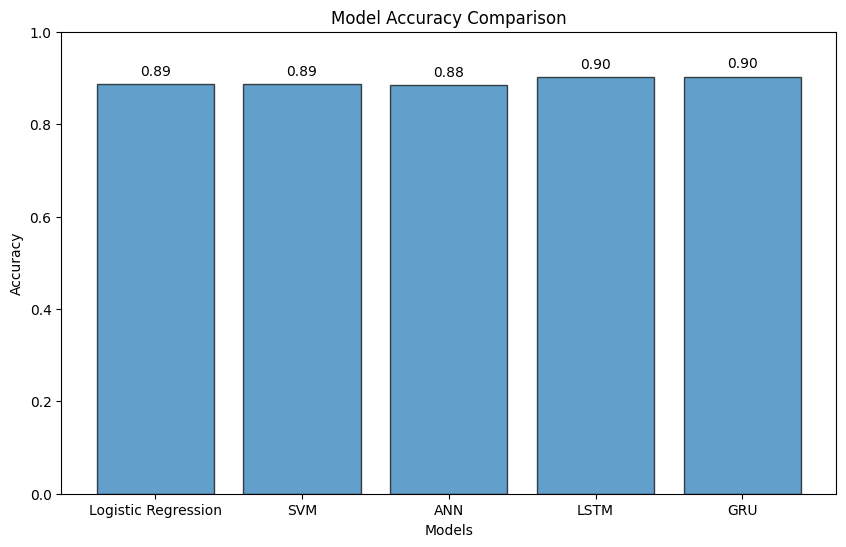

In [ ]:
lr_accuracy = accuracy_score(y_test_tfidf, lr_predictions)
svm_accuracy = accuracy_score(y_test_tfidf, svm_predictions)
ann_accuracy = ann_model.evaluate(X_test, y_test, verbose=0)[1]
lstm_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)[1]
gru_accuracy = gru_model.evaluate(X_test, y_test, verbose=0)[1]

model_names = ['Logistic Regression', 'SVM', 'ANN', 'LSTM', 'GRU']
accuracies = [lr_accuracy, svm_accuracy, ann_accuracy, lstm_accuracy, gru_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, alpha=0.7, edgecolor='black')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=10)
plt.show()

### Prediction Function
- A function is defined to predict sentiment for user-input text.
- The text is preprocessed, tokenized, and padded before being fed into the LSTM model.
- The predicted sentiment (positive or negative) and confidence score are displayed.


In [ ]:
def predict_sentiment(user_input, model, tokenizer, max_length):
    processed_input = preprocess_text(user_input)
    sequence = tokenizer.texts_to_sequences([processed_input])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(padded_sequence)
    sentiment = "Positive" if prediction >= 0.5 else "Negative"
    return sentiment, prediction[0][0]

while True:
    user_input = input("Enter a review (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        print("Exiting...")
        break
    sentiment, confidence = predict_sentiment(user_input, lstm_model, tokenizer, max_length)
    print(f"Review: {user_input}")
    print(f"Sentiment: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Review: Absolutely fantastic! The product exceeded my expectations in every way. Highly recommended!
Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Review: Terrible experience. The product stopped working after just one use. Very disappointed.
Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Review: The quality is awful, and it doesn’t match the description at all. Waste of money.
Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Review: I was skeptical at first, but this product has completely won me over. From the packaging to the performance, everything about it screams quality. It arrived on time, and setting it up was a breeze thanks to the detailed instructions provided. I've been using it for a few weeks now, and it’s been working flawlessly without any issues. The materials feel premium, and it looks great too. What impressed me the most is how well it performs under heavy use—truly above and beyond my expectati